-들어가기전 버전 맞춰주기

In [16]:
!pip uninstall tensorflow
!pip install tensorflow==2.16.1

Found existing installation: tensorflow 2.16.1
Uninstalling tensorflow-2.16.1:
  Would remove:
    /usr/local/bin/import_pb_to_tensorboard
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.10/dist-packages/tensorflow-2.16.1.dist-info/*
    /usr/local/lib/python3.10/dist-packages/tensorflow/*
Proceed (Y/n)? Y
  Successfully uninstalled tensorflow-2.16.1
  Using cached tensorflow-2.16.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (589.8 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.16.1 which is incompatible.


In [3]:
!pip uninstall keras
!pip install keras==3.3.3

Found existing installation: keras 3.3.3
Uninstalling keras-3.3.3:
  Would remove:
    /usr/local/lib/python3.10/dist-packages/keras-3.3.3.dist-info/*
    /usr/local/lib/python3.10/dist-packages/keras/*
Proceed (Y/n)? Y
  Successfully uninstalled keras-3.3.3
  Using cached keras-3.3.3-py3-none-any.whl (1.1 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.15.1 requires tensorflow<2.16,>=2.15, but you have tensorflow 2.16.1 which is incompatible.


In [2]:
import tensorflow as tf
import keras

print(tf.__version__)
print(keras.__version__)

2.16.1
3.3.3


- train

In [3]:
#데이터 불러오기
actions = [
    'push',
    'hand_shake',
    'spin'
]

data = np.concatenate([
    np.load('sample_data/seq_push_1717166069.npy'),
    np.load('sample_data/seq_hand_shake_1717166069.npy'),
    np.load('sample_data/seq_spin_1717166069.npy')
], axis=0)

data.shape

(2600, 30, 100)

In [4]:
#라벨, 데이터 구분.
x_data = data[:, :, :-1]
labels = data[:, 0, -1]

print(x_data.shape)
print(labels.shape)

(2600, 30, 99)
(2600,)


In [5]:
from tensorflow.keras.utils import to_categorical

y_data = to_categorical(labels, num_classes=len(actions))
y_data.shape

(2600, 3)

In [6]:
from sklearn.model_selection import train_test_split

x_data = x_data.astype(np.float32)
y_data = y_data.astype(np.float32)

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.1, random_state=2021)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)

(2340, 30, 99) (2340, 3)
(260, 30, 99) (260, 3)


In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

#모델 만들기

model = Sequential([
    LSTM(64, activation='relu', input_shape=x_train.shape[1:3]),
    Dense(32, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 64)                  │          41,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │              99 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 44,163 (172.51 KB)

 Trainable params: 44,163 (172.51 KB)

 Non-trainable params: 0 (0.00 B)

학습시키기.

In [8]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('models/model.keras', monitor='val_accuracy', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=50, verbose=1, mode='auto')
    ]
)


Epoch 1/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - acc: 0.5257 - loss: 7.1717 - val_acc: 0.9346 - val_loss: 0.2343 - learning_rate: 0.0010
Epoch 2/200


/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/model_checkpoint.py:206: UserWarning: Can save best model only with val_accuracy available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)
/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_accuracy` which is not available. Available metrics are: acc,loss,val_acc,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


74/74 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - acc: 0.9568 - loss: 0.1759 - val_acc: 0.8346 - val_loss: 2.2771 - learning_rate: 0.0010
Epoch 3/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - acc: 0.8111 - loss: 1.0935 - val_acc: 0.9846 - val_loss: 0.1052 - learning_rate: 0.0010
Epoch 4/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - acc: 0.9862 - loss: 0.0641 - val_acc: 1.0000 - val_loss: 0.0253 - learning_rate: 0.0010
Epoch 5/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - acc: 0.9961 - loss: 0.0228 - val_acc: 1.0000 - val_loss: 0.0145 - learning_rate: 0.0010
Epoch 6/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - acc: 0.9989 - loss: 0.0132 - val_acc: 1.0000 - val_loss: 0.0087 - learning_rate: 0.0010
Epoch 7/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.9949 - loss: 0.0227 - val_acc: 0.9962 - val_loss: 0.0148 - learning_rate: 0.0010
Epoch 8/200
74/74 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - acc: 0.9920 - loss: 0.0236 - val_acc: 1.0000 - val_loss: 0.0035 - learning_rate: 0.0010
Epoch 9/200
74/74 

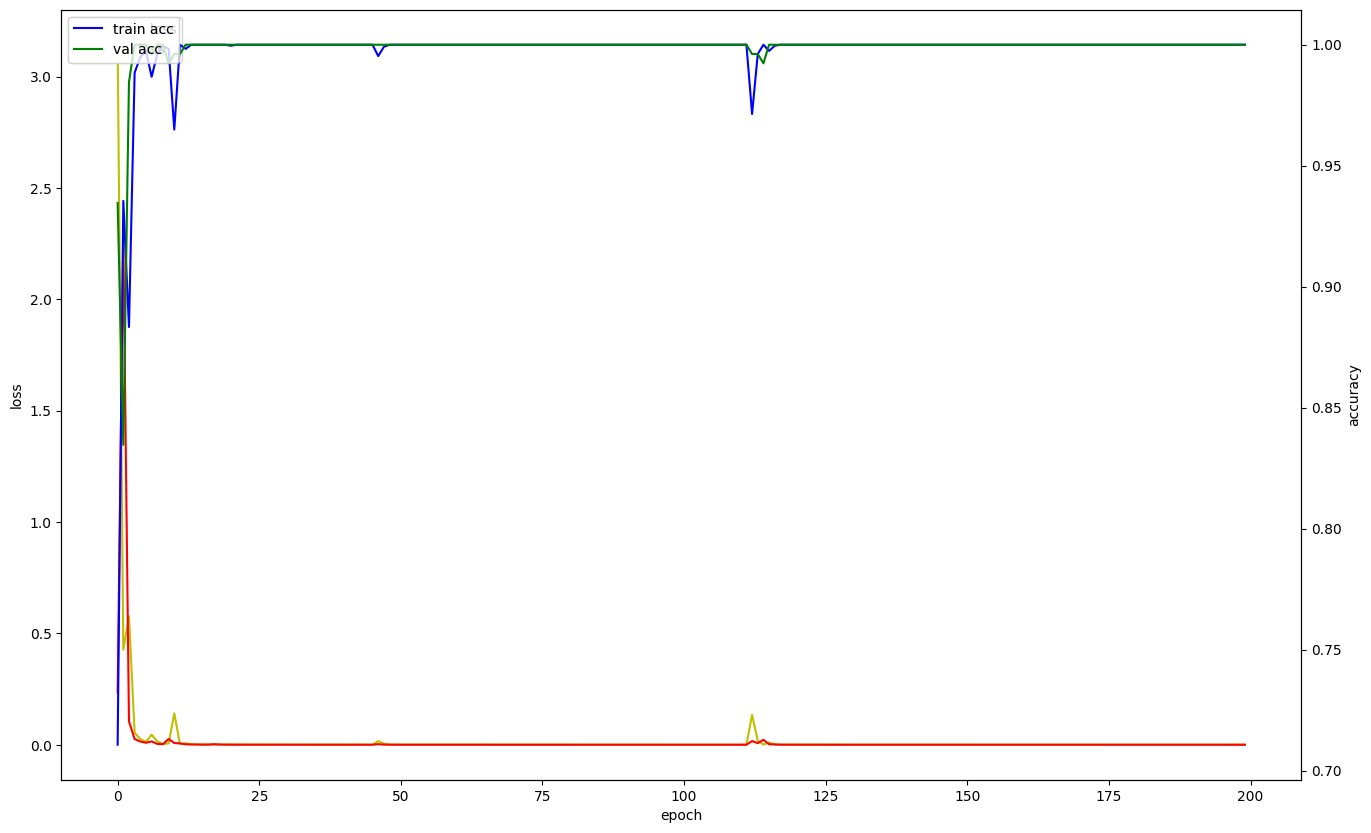

In [9]:
import matplotlib.pyplot as plt

#학습결과 체크
fig, loss_ax = plt.subplots(figsize=(16, 10))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper left')

acc_ax.plot(history.history['acc'], 'b', label='train acc')
acc_ax.plot(history.history['val_acc'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

모델저장해주기.

In [10]:

model.save('models/model.keras')

In [11]:
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import load_model

#confusion matrix로 모델링결과 체크.

model = load_model('models/model.keras')

y_pred = model.predict(x_val)

multilabel_confusion_matrix(np.argmax(y_val, axis=1), np.argmax(y_pred, axis=1))

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


array([[[169,   0],
        [  0,  91]],

       [[164,   0],
        [  0,  96]],

       [[187,   0],
        [  0,  73]]])